In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import tensorflow as tf
from tqdm import tqdm

import math
import torch.nn.functional as F
from sklearn.metrics import f1_score, mean_squared_error
from fastprogress import master_bar, progress_bar

%matplotlib inline

In [0]:
BATCH_SIZE = 16           
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 30                               # Maximum number of training epochs

# Input List of Dataset

In [0]:
INDEX_FEATURE = 0 # Select feature for training
FEATURES = ['dyskinesia', 'on_off', 'tremor']

In [0]:
PATH_FOLDER = '/content/drive/My Drive/Beat-PD/List_train_test'

def read_lst(file_name):
    list_ = []
    with open(file_name) as f:
        for element in f:
            list_.append(element.split('\n')[0])
        f.close()
    return list_ 

In [0]:
train_list = {}
val_list = {}

for fe in FEATURES:
    train_list[fe] = read_lst(os.path.join(PATH_FOLDER, 'train_train_nonan_' + fe +'.lst'))
    val_list[fe] = read_lst(os.path.join(PATH_FOLDER, 'train_val_nonan_' + fe + '.lst'))

# Data Preprocessing

In [0]:
LABEL_PATH = '/content/drive/My Drive/Beat-PD/Train_Dataset/Data_Train_CIS-PD/Data_Train_CIS-PD/cis-pd.data_labels/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'
LABEL_DF = pd.read_csv(LABEL_PATH)
# LABEL_DF.dropna(axis=0, inplace=True)
LABEL_DF.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [0]:
TRAIN_PATH = '/content/drive/My Drive/Beat-PD/Train_Dataset/Data_Train_CIS-PD/Data_Train_CIS-PD/cis-pd.training_data/training_data/' 
LABEL_PATH = '/content/drive/My Drive/Beat-PD/Train_Dataset/Data_Train_CIS-PD/Data_Train_CIS-PD/cis-pd.data_labels/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'

def preprocessing(name, train_path):
    # Get data for training
    df = pd.read_csv(os.path.join(train_path, name + '.csv'))
    df.drop('Timestamp', axis=1, inplace=True)
    data = torch.tensor(df.values).float()
    data = torch.unsqueeze(data, 0)
    data = torch.unsqueeze(data, 0)

    # Get label for training
    label = LABEL_DF.loc[LABEL_DF['measurement_id'] == name, FEATURES]
    label = torch.tensor(label.values).long()
    return data, label

# Create DataGenerator

In [0]:
class fundus_dataset(Dataset):
    def __init__(self, path_folder_csv, file_names, path_label_csv):
        super().__init__()

        self.folder = path_folder_csv
        self.file_names = file_names
        self.label_df = pd.read_csv(path_label_csv)

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        # Get data for training
        df = pd.read_csv(os.path.join(self.folder, self.file_names[index] + '.csv'))
        df.drop('Timestamp', axis=1, inplace=True)
        data = torch.tensor(df.values)
        data = torch.unsqueeze(data, 0)
        data = torch.unsqueeze(data, 0)

        # Get label for training
        label = self.label_df.loc[self.label_df['measurement_id'] == self.file_names[index], FEATURES[INDEX_FEATURE]]
        label = torch.tensor(label.values[0])
        return data.float(), label

In [0]:
def custom_collate(batch):
    data = [item[0] for item in batch]
    label = [item[1] for item in batch]
    target = torch.tensor(label)
    return data, target

In [0]:
train_dataset = fundus_dataset(TRAIN_PATH, train_list[FEATURES[INDEX_FEATURE]], LABEL_PATH)
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=8, 
                              pin_memory=True, 
                              collate_fn=custom_collate)

In [0]:
val_dataset = fundus_dataset(TRAIN_PATH, val_list[FEATURES[INDEX_FEATURE]], LABEL_PATH)
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=1, 
                            shuffle=True, 
                            num_workers=8,  
                            pin_memory=True)

# Design Model

In [0]:
class Model_1(nn.Module):
    def __init__(self, num_classes):
        super(Model_1, self).__init__()
        
        self.out_conv1 = 64
        self.out_conv2 = 128
        self.num_classes = num_classes

        # extract features
        conv1 = nn.Conv2d(in_channels=1, out_channels=self.out_conv1, kernel_size=(10, 3), stride=(1, 1), padding=(1,1))
        conv2 = nn.Conv2d(in_channels=self.out_conv1, out_channels=self.out_conv2, kernel_size=(5, 3), stride=(5, 3))
        # extract relationship between each features
        LSTM1 = nn.LSTM(input_size = 1, hidden_size = 1, num_layers=1)

        # sequential
        self.cnn = nn.Sequential(
            conv1, nn.ReLU(), 
            conv2, nn.ReLU()) 
        
        self.lstm = nn.Sequential( 
            LSTM1)

        self.fc = nn.Sequential(
            nn.Linear(self.out_conv2, num_classes))

    def forward(self, input):

        x1 = self.cnn(input).transpose(1, 2).view(-1, self.out_conv2, 1)
        # print(x1.shape)
        x2, hc_t = self.lstm(x1)
        # print(x2.shape)
        x3 = x2[-1].view(self.out_conv2)
        # print(x3.shape)
        x4 = self.fc(x3)
        # print(x4.shape)
        return x4


In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [0]:
model = Model_1(num_classes = 1).to(device)
model

Model_1(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 3), stride=(5, 3))
    (3): ReLU()
  )
  (lstm): Sequential(
    (0): LSTM(1, 1)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [0]:
# x, y = train_dataset[0]
# model(x.to(device))

# Loss and Optim

In [0]:
loss = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), 
                   lr=LEARNING_RATE, 
                   betas=(0.9, 0.999), 
                   eps=1e-8, 
                   weight_decay=1e-5)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                    factor = LEARNING_RATE_SCHEDULE_FACTOR, 
                                                    patience = LEARNING_RATE_SCHEDULE_PATIENCE, 
                                                    mode = 'min',
                                                    verbose=True)

# Training each epoch

In [0]:
def epoch_training(epoch, model, train_dataset, device, loss_criteria, optimizer):
    model.train()
    training_loss = 0

    for batch, (xx, yy) in enumerate(train_dataset):
        optimizer.zero_grad()
        yhats = torch.FloatTensor().to(device)
        yy = yy.to(device)

        for (x, y) in zip(xx, yy):
            x = x.to(device)
            yhat = model(x)
            yhats = torch.cat((yhats, yhat), 0)

        # print(f"y={yy}, yhats = {yhats}")
        loss = loss_criteria(yhats, yy)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

        # #
        # if batch == 0:
        #     break
        # #
        del x, y, loss, yhats
    del xx, yy
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    return training_loss/len(train_dataset)

# Evaluate Model

In [0]:
def evaluating(epoch, model, val_dataset, device, loss_criteria):
    model.eval()
    val_loss = 0       

    with torch.no_grad(): 
        for step, (xx, yy) in enumerate(val_dataset):
            x = xx.to(device).squeeze(0)
            yy = yy.to(device)
            yhats = model(x)
            
            # print(f"yhat={yhats}/n y={yy}")
            loss = loss_criteria(yhats, yy)
            val_loss += loss

            # #
            # if step == 0:
            #     break
            # #

    del xx, yy, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    return val_loss/len(val_dataset)

# Fully Training

In [0]:
name_model = 'model_3_dyskinesia.pth'

In [0]:
best_mse = 10
model_path = '/content/drive/My Drive/Beat-PD/CNN-LSTM-FC/pretrained_model/' + name_model

info_df = pd.DataFrame({
                       "epoch": [],
                       "train_loss": [],
                       "val_loss": []})

for epoch in tqdm(range(MAX_EPOCHS)):
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss, optimizer)
    val_loss = evaluating(epoch, model, val_dataloader, device, loss)

    print(f"\nEpoch {epoch}: training losses= {train_loss}; val_loss= {val_loss};")
    info_df = info_df.append(pd.DataFrame({"epoch":[epoch], 
                                 "train_loss":[train_loss], 
                                 "val_loss":[val_loss.item()]}), ignore_index=True)

    lr_scheduler.step(val_loss)

    if best_mse > val_loss:
        print(f"In epoch {epoch} - Improve MSE from {best_mse} to {val_loss}")
        best_mse = val_loss
        torch.save(model.state_dict(), model_path)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch 0: training losses= 0.9408121298138912; val_loss= 0.8198668956756592;
In epoch 0 - Improve MSE from 10 to 0.8198668956756592


  7%|▋         | 2/30 [14:09<3:30:49, 451.77s/it]


Epoch 1: training losses= 0.8453324801073625; val_loss= 0.812961220741272;
In epoch 1 - Improve MSE from 0.8198668956756592 to 0.812961220741272


 10%|█         | 3/30 [20:04<3:10:07, 422.48s/it]


Epoch 2: training losses= 0.8446109105761235; val_loss= 0.8127484917640686;
In epoch 2 - Improve MSE from 0.812961220741272 to 0.8127484917640686


 13%|█▎        | 4/30 [25:56<2:54:00, 401.54s/it]


Epoch 3: training losses= 0.8353717951820447; val_loss= 0.8207479119300842;


 17%|█▋        | 5/30 [31:45<2:40:42, 385.70s/it]


Epoch 4: training losses= 0.8355412443096821; val_loss= 0.8138422966003418;


 20%|██        | 6/30 [37:42<2:30:48, 377.03s/it]


Epoch 5: training losses= 0.8289990207323661; val_loss= 0.8218095898628235;


 23%|██▎       | 7/30 [43:35<2:21:50, 370.01s/it]


Epoch 6: training losses= 0.8280106622439164; val_loss= 0.8253451585769653;


 27%|██▋       | 8/30 [49:21<2:13:00, 362.73s/it]


Epoch 7: training losses= 0.8280780733777926; val_loss= 0.81731778383255;


 30%|███       | 9/30 [55:06<2:05:03, 357.32s/it]


Epoch 8: training losses= 0.832006963972862; val_loss= 0.8275415301322937;
Epoch     9: reducing learning rate of group 0 to 1.0000e-04.


 33%|███▎      | 10/30 [1:00:46<1:57:25, 352.25s/it]


Epoch 9: training losses= 0.8196656772723565; val_loss= 0.8203616142272949;


 37%|███▋      | 11/30 [1:06:33<1:50:59, 350.50s/it]


Epoch 10: training losses= 0.8129240062374335; val_loss= 0.8173524141311646;


 40%|████      | 12/30 [1:12:22<1:45:02, 350.12s/it]


Epoch 11: training losses= 0.8100093204814655; val_loss= 0.8163424730300903;


 43%|████▎     | 13/30 [1:18:06<1:38:43, 348.44s/it]


Epoch 12: training losses= 0.8090664457816344; val_loss= 0.8169125914573669;


 47%|████▋     | 14/30 [1:23:57<1:33:06, 349.15s/it]


Epoch 13: training losses= 0.8071347434933369; val_loss= 0.8165952563285828;


 50%|█████     | 15/30 [1:29:51<1:27:36, 350.46s/it]


Epoch 14: training losses= 0.8059151648328855; val_loss= 0.8170702457427979;
Epoch    15: reducing learning rate of group 0 to 1.0000e-05.


 53%|█████▎    | 16/30 [1:35:51<1:22:26, 353.29s/it]


Epoch 15: training losses= 0.8038244384985703; val_loss= 0.8170528411865234;


 57%|█████▋    | 17/30 [1:41:49<1:16:52, 354.79s/it]


Epoch 16: training losses= 0.8043250504594582; val_loss= 0.817131519317627;


 60%|██████    | 18/30 [1:47:42<1:10:49, 354.15s/it]


Epoch 17: training losses= 0.8037020890758588; val_loss= 0.8171138167381287;


 63%|██████▎   | 19/30 [1:53:37<1:04:58, 354.42s/it]


Epoch 18: training losses= 0.8040164726284834; val_loss= 0.8171610832214355;


 67%|██████▋   | 20/30 [1:59:30<59:00, 354.04s/it]  


Epoch 19: training losses= 0.8038287306061158; val_loss= 0.8171007633209229;


 70%|███████   | 21/30 [2:05:25<53:10, 354.47s/it]


Epoch 20: training losses= 0.8034776426278628; val_loss= 0.8171213269233704;
Epoch    21: reducing learning rate of group 0 to 1.0000e-06.


 73%|███████▎  | 22/30 [2:11:15<47:05, 353.20s/it]


Epoch 21: training losses= 0.8030737907840655; val_loss= 0.8171223402023315;


 77%|███████▋  | 23/30 [2:17:04<41:02, 351.85s/it]


Epoch 22: training losses= 0.8037573081942705; val_loss= 0.8171281814575195;


 80%|████████  | 24/30 [2:22:54<35:07, 351.25s/it]


Epoch 23: training losses= 0.8046749325898978; val_loss= 0.8171277642250061;


 83%|████████▎ | 25/30 [2:28:48<29:20, 352.06s/it]


Epoch 24: training losses= 0.8035184643589534; val_loss= 0.817137598991394;


 87%|████████▋ | 26/30 [2:34:47<23:36, 354.11s/it]


Epoch 25: training losses= 0.8038737768164048; val_loss= 0.8171396255493164;


 90%|█████████ | 27/30 [2:40:48<17:49, 356.35s/it]


Epoch 26: training losses= 0.8031439471703309; val_loss= 0.817133903503418;
Epoch    27: reducing learning rate of group 0 to 1.0000e-07.


 93%|█████████▎| 28/30 [2:46:44<11:52, 356.03s/it]


Epoch 27: training losses= 0.8036210634387456; val_loss= 0.8171337246894836;


 97%|█████████▋| 29/30 [2:52:38<05:55, 355.42s/it]


Epoch 28: training losses= 0.8034819616721227; val_loss= 0.8171330690383911;


100%|██████████| 30/30 [2:58:33<00:00, 355.42s/it]


Epoch 29: training losses= 0.8033112963804832; val_loss= 0.8171334862709045;


# Chart and Result

In [0]:
def draw_chart(df):
    df.plot(kind='line',x='epoch',y=['train_loss', 'val_loss'], figsize=(12,5))
    plt.show()

Best MSE =  tensor(0.8127, device='cuda:0')


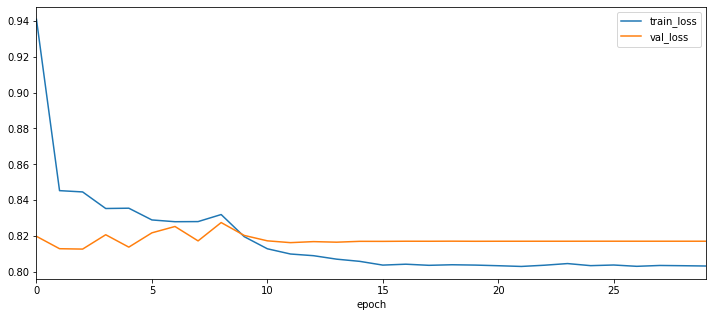

In [0]:
print("Best MSE = ",best_mse)
draw_chart(info_df)